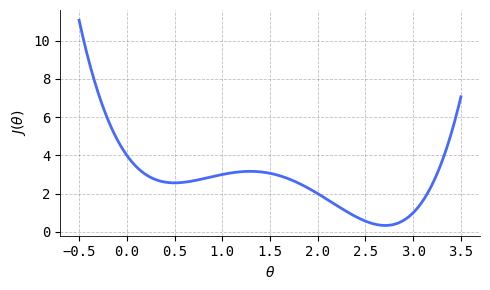

In [75]:
import torch
from torch.utils.data import DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#import matplotlib_inline.backend_inline
plt.style.use('./aux-files/custom_style_light.mplstyle')
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
blue = '#486AFB'
magenta = '#FD46FC'

def J(theta):
    return (theta ** 4) - 6 * (theta ** 3) + 11 * (theta ** 2) - 7 * theta + 4

grid = torch.linspace(start=-0.5, end=3.5, steps=300)
plt.plot(grid, J(grid))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$J(\theta)$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

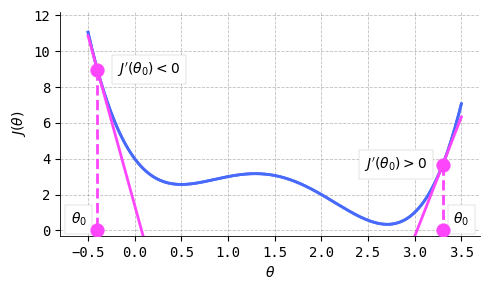

In [76]:
def J_prime(theta):
    return 4 * (theta ** 3) - 18 * (theta ** 2) + 22 * theta - 7

plt.plot(grid, J(grid), color=blue)
plt.plot(grid, J_prime(-0.4) * (grid + 0.4) + J(-0.4), color=magenta, zorder=10)
plt.scatter(-0.4, J(-0.4), color=magenta, s=100, zorder=15)
plt.scatter(-0.4, 0, color=magenta, s=100, zorder=20)
plt.plot([-0.4, -0.4], [J(-0.4), 0], color=magenta, linestyle='--')
plt.xlim(-0.8, 3.7)
plt.ylim(-0.3, 12.2)
plt.text(-0.6, 0.6, r'$\theta_0$', ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))
plt.text(0.15, J(-0.4), r"$J'(\theta_0)<0$", ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))

plt.plot(grid, J(grid))
plt.plot(grid, J_prime(3.3) * (grid - 3.3) + J(3.3))
plt.scatter(3.3, J(3.3), color=magenta, s=100, zorder=10)
plt.scatter(3.3, 0, color=magenta, s=100, zorder=10)
plt.plot([3.3, 3.3], [J(3.3), 0], color=magenta, linestyle='--')
plt.text(3.5, 0.6, r'$\theta_0$', ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))
plt.text(2.8, J(3.3), r"$J'(\theta_0)>0$", ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))

plt.xlabel(r'$\theta$')
plt.ylabel(r'$J(\theta)$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

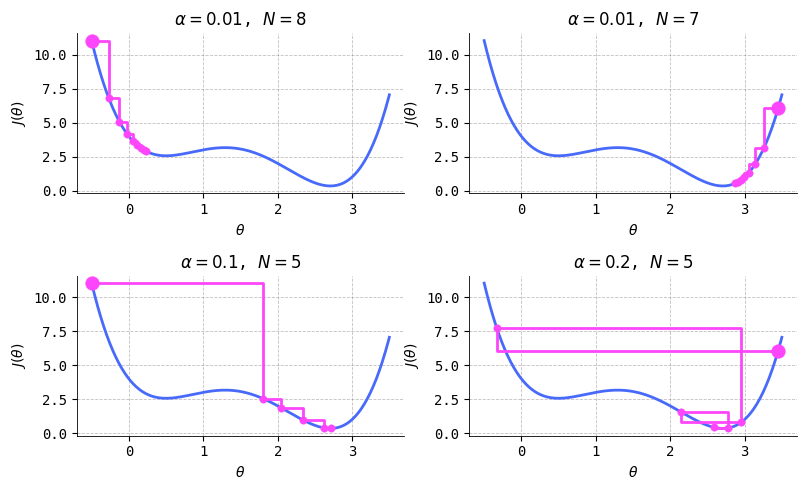

In [77]:
# define the gradient descent function
def GD(theta, J, num_steps, lr, lr_decay_rate=0):
        
    # get initial objective value, compute the gradient
    objective = J(theta)
    objective.backward()
    
    # initialize lists to track objective values and thetas
    running_objectives = [objective.detach().view(1)]
    running_thetas = [theta.detach().clone()]

    # begin gradient descent loop
    for t in range(num_steps):
        
        # take a step and update the theta
        with torch.no_grad():
            g = (1 - lr_decay_rate) ** (t + 1) * theta.grad
            theta -= lr * g
            
        # append updated theta to running list
        running_thetas.append(theta.detach().clone())

        # zero out the gradient to prepare for the next iteration
        theta.grad.zero_()

        # get updated objective, compute the gradient
        objective = J(theta)
        objective.backward()

        # append updated objective value to running list
        running_objectives.append(objective.detach().view(1))

    # output tensors instead of lists
    running_thetas = torch.row_stack(running_thetas)
    running_objectives = torch.row_stack(running_objectives)

    return running_thetas, running_objectives

# plot objective function
grid = torch.linspace(start=-0.5, end=3.5, steps=300)
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))
for axis in axes.flatten():
    axis.plot(grid, J(grid))

# parameters for gradient descent
gd_parameters = {'theta': [torch.tensor([-0.5], requires_grad=True), torch.tensor([3.45], requires_grad=True), torch.tensor([-0.5], requires_grad=True), torch.tensor([3.45], requires_grad=True)],
                 'num_steps': [8, 7, 5, 5],
                 'lr': [1e-2, 1e-2, 1e-1, 2e-1]}

# run gradient descent and plot
for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    running_parameters, running_objectives = GD(**gd_parameters_slice, J=J)
    lr = gd_parameters_slice['lr']
    num_steps = gd_parameters_slice['num_steps']
    axis.step(x=running_parameters, y=running_objectives, where='post', color=magenta, zorder=2)
    axis.scatter(x=running_parameters, y=running_objectives, s=30, color=magenta, zorder=2)
    axis.scatter(x=running_parameters[0], y=running_objectives[0], s=100, color=magenta, zorder=2)
    axis.set_xlabel(r'$\theta$')
    axis.set_ylabel(r'$J(\theta)$')
    axis.set_title(fr'$\alpha={lr}$, $N={num_steps}$')
plt.tight_layout()

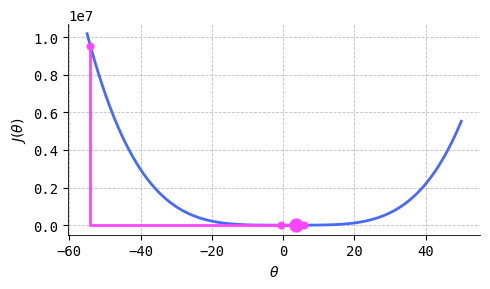

In [78]:
gd_parameters = {'theta': torch.tensor([3.5], requires_grad=True),
                 'num_steps': 3,
                 'lr': 2e-1,}

running_parameters, running_objectives = GD(**gd_parameters, J=J)

grid = torch.linspace(start=-55, end=50, steps=300)
plt.plot(grid, J(grid))
plt.step(x=running_parameters, y=running_objectives, where='post', color=magenta, zorder=2)
plt.scatter(x=running_parameters, y=running_objectives, s=30, color=magenta, zorder=2)
plt.scatter(x=running_parameters[0], y=running_objectives[0], s=100, color=magenta, zorder=2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$J(\theta)$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

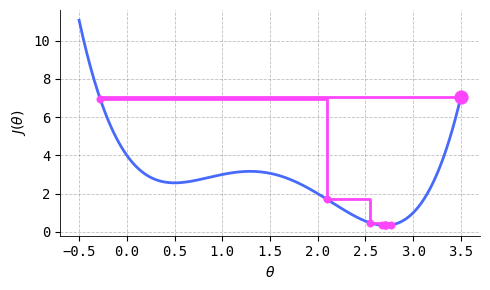

In [79]:
gd_parameters = {'theta': torch.tensor([3.5], requires_grad=True),
                 'num_steps': 8,
                 'lr': 2e-1,}

running_parameters, running_objectives = GD(**gd_parameters, J=J, lr_decay_rate=0.1)

grid = torch.linspace(start=-0.5, end=3.5, steps=300)
plt.plot(grid, J(grid))
plt.step(x=running_parameters, y=running_objectives, where='post', color=magenta, zorder=2)
plt.scatter(x=running_parameters, y=running_objectives, s=30, color=magenta, zorder=2)
plt.scatter(x=running_parameters[0], y=running_objectives[0], s=100, color=magenta, zorder=2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$J(\theta)$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

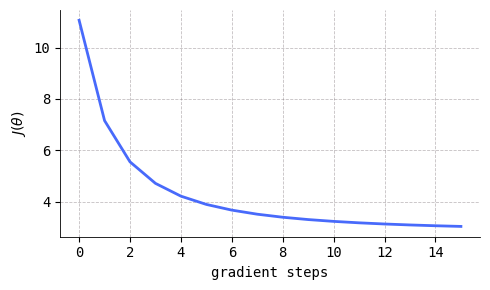

In [80]:
gd_parameters = {'theta': torch.tensor([-0.5], requires_grad=True),
                 'num_steps': 15,
                 'lr': 1e-2}

running_parameters, running_objectives = GD(**gd_parameters, J=J, lr_decay_rate=0.1)

plt.plot(range(len(running_objectives)), running_objectives)
plt.xlabel('gradient steps')
plt.ylabel('$J(\\theta)$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

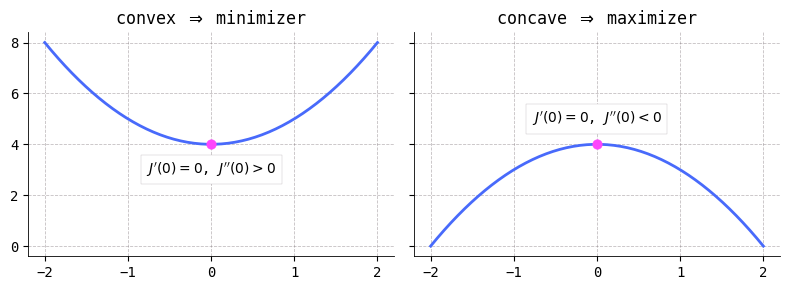

In [81]:
def f(x):
    return x ** 2 + 4

def g(x):
    return -x ** 2 + 4

functions = [f, g]
grid = np.linspace(-2, 2)
_, axes = plt.subplots(ncols=2, figsize=(8, 3), sharey=True, sharex=True)

for i, (function, axis) in enumerate(zip(functions, axes)):
    axis.plot(grid, function(grid))
    axis.scatter(0, 4, s=50, color=magenta, zorder=3)
    if i == 0:
        axis.text(0, 3, "$J '(0) = 0$, $J ''(0)>0$", ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))
        axis.set_title('convex $\Rightarrow$ minimizer')
    else:
        axis.text(0, 5, "$J '(0) = 0$, $J ''(0)<0$", ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))
        axis.set_title('concave $\Rightarrow$ maximizer')

plt.tight_layout()

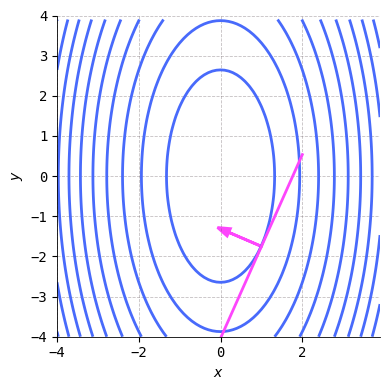

In [82]:
def f(x, y):
    return -4 * x ** 2 - y ** 2 + 15

grid = np.linspace(0, 2)
x, y = np.mgrid[-4:4:0.1, -4:4:0.1]
z = f(x, y)

def tangent_line(x):
    return (8 / 3.5) * (x - 1) - 1.75

plt.contour(x, y, z, levels=10, colors=blue, linestyles='solid')
plt.plot(grid, tangent_line(grid), color=magenta)
plt.arrow(1, -1.75, -8 / 10, 3.5 / 10, head_width=0.2, head_length=0.3, fc=magenta, ec=magenta, linewidth=2)
plt.gcf().set_size_inches(4, 4)
plt.ylim(-4, 4)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()

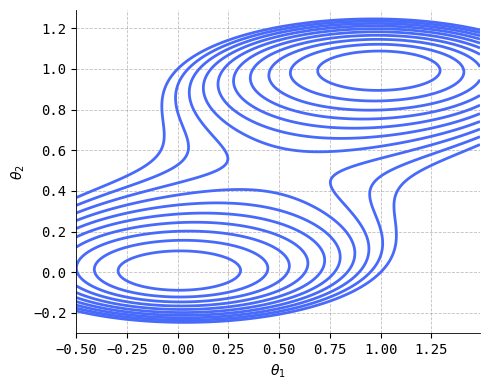

In [83]:
# define the objective function
def J(theta):
    Q = torch.tensor([[1.0, 0], [0, 10.0]])
    factor1 = torch.sum((torch.tensordot(theta, Q, dims=1) * theta), dim=-1)
    factor2 = torch.sum((torch.tensordot(theta - 1, Q, dims=1) * (theta - 1)), dim=-1)
    return factor1 * factor2

x, y = np.mgrid[-0.50:1.5:0.01, -0.3:1.3:0.01]
grid = np.dstack((x, y))
grid = torch.tensor(grid, dtype=torch.float32)

plt.contour(x, y, J(grid), levels=range(11), colors=blue)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.gcf().set_size_inches(w=5, h=4)
plt.tight_layout()

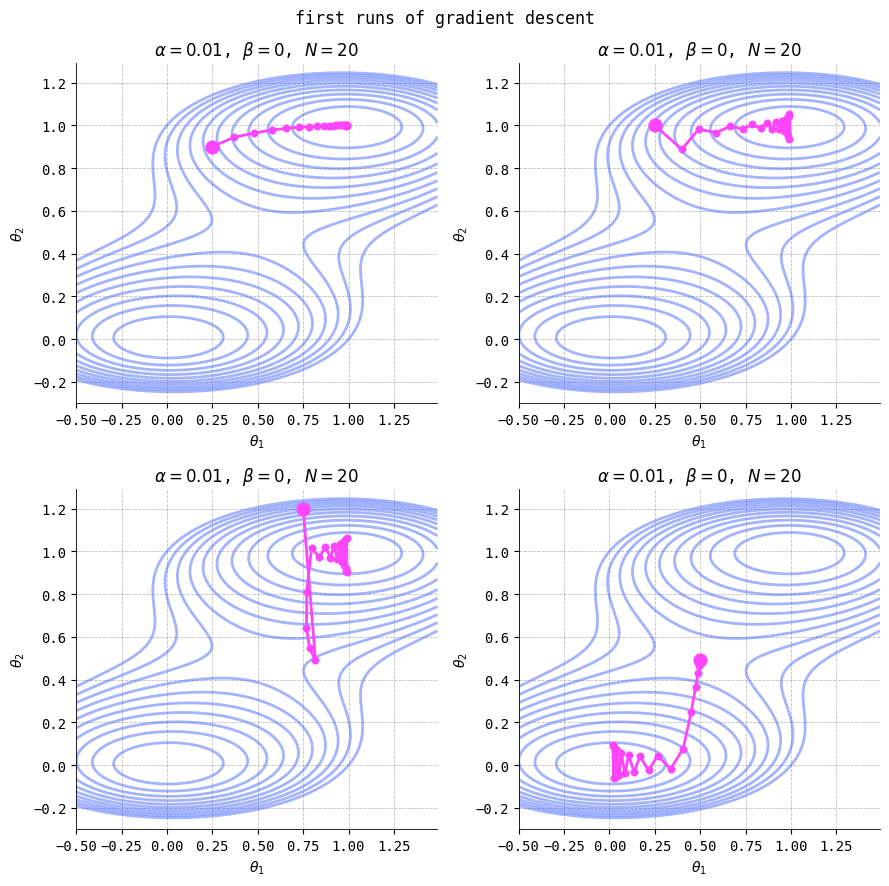

In [87]:
# plot the objective function
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
for axis in axes.flatten():
    axis.contour(x, y, J(grid), levels=range(11), colors=blue, alpha=0.5)

# parameters for gradient descent
gd_parameters = {'theta': [torch.tensor([0.25, 0.9], requires_grad=True),
                           torch.tensor([0.25, 1], requires_grad=True),
                           torch.tensor([0.75, 1.2], requires_grad=True),
                           torch.tensor([0.5, 0.49], requires_grad=True)],
                 'num_steps': [20, 20, 20, 20],
                 'lr': [1e-2, 1e-2, 1e-2, 1e-2]}

# run gradient descent and plot
for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    running_parameters, running_objectives = GD(**gd_parameters_slice, J=J)
    lr = gd_parameters_slice['lr']
    num_steps = gd_parameters_slice['num_steps']
    axis.plot(running_parameters[:, 0], running_parameters[:, 1], color=magenta)
    axis.scatter(running_parameters[:, 0], running_parameters[:, 1], s=30, color=magenta, zorder=2)
    axis.scatter(x=running_parameters[0, 0], y=running_parameters[0, 1], s=100, color=magenta, zorder=2)
    axis.set_xlabel(r'$\theta_1$')
    axis.set_ylabel(r'$\theta_2$')
    axis.set_title(fr'$\alpha={lr}$, $\beta=0$, $N={num_steps}$')
    fig.suptitle('first runs of gradient descent')
plt.tight_layout()

In [74]:
from torch.autograd.functional import hessian
from torch.linalg import eig

H = hessian(J, inputs=torch.tensor([1.0, 1.0]))
evals, evecs = eig(H)
evals


tensor([ 22.+0.j, 220.+0.j])

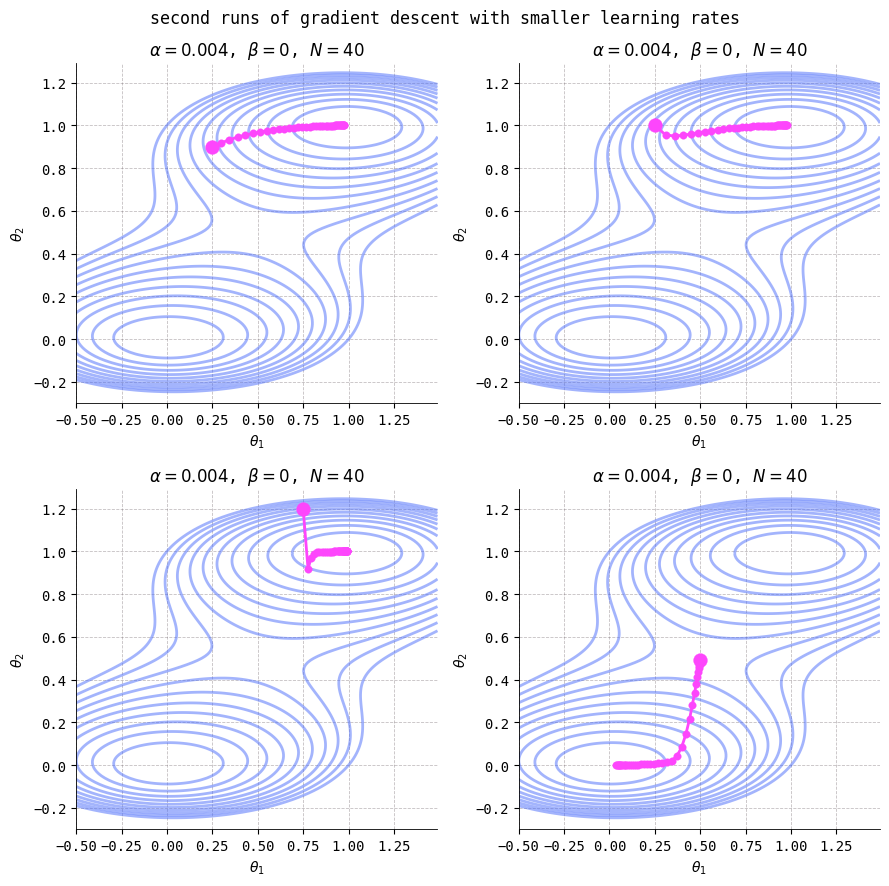

In [88]:
# plot the objective function
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
for axis in axes.flatten():
    axis.contour(x, y, J(grid), levels=range(11), colors=blue, alpha=0.5)

# parameters for gradient descent
gd_parameters = {'theta': [torch.tensor([0.25, 0.9], requires_grad=True),
                           torch.tensor([0.25, 1], requires_grad=True),
                           torch.tensor([0.75, 1.2], requires_grad=True),
                           torch.tensor([0.5, 0.49], requires_grad=True)],
                 'num_steps': [40, 40, 40, 40],
                 'lr': [4e-3, 4e-3, 4e-3, 4e-3]}

# run gradient descent and plot
for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    running_parameters, running_objectives = GD(**gd_parameters_slice, J=J)
    lr = gd_parameters_slice['lr']
    num_steps = gd_parameters_slice['num_steps']
    axis.plot(running_parameters[:, 0], running_parameters[:, 1], color=magenta)
    axis.scatter(running_parameters[:, 0], running_parameters[:, 1], s=30, color=magenta, zorder=2)
    axis.scatter(x=running_parameters[0, 0], y=running_parameters[0, 1], s=100, color=magenta, zorder=2)
    axis.set_xlabel(r'$\theta_1$')
    axis.set_ylabel(r'$\theta_2$')
    axis.set_title(fr'$\alpha={lr}$, $\beta=0$, $N={num_steps}$')
    fig.suptitle('second runs of gradient descent with smaller learning rates')
plt.tight_layout()

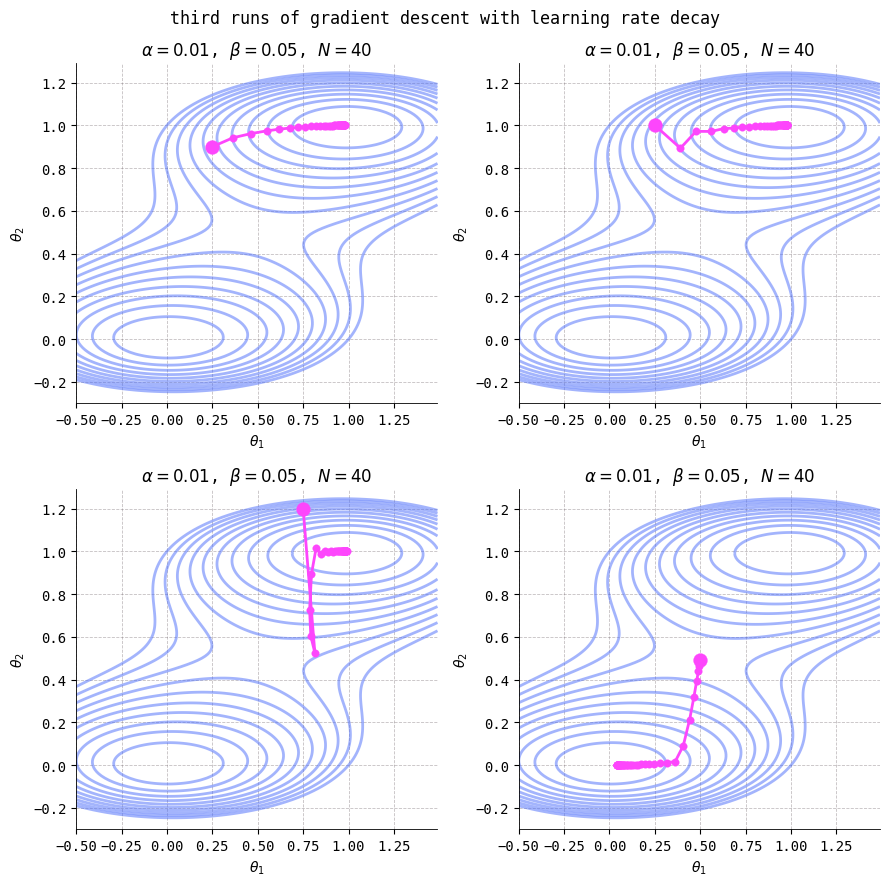

In [94]:
# plot the objective function
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
for axis in axes.flatten():
    axis.contour(x, y, J(grid), levels=range(11), colors=blue, alpha=0.5)

# parameters for gradient descent
gd_parameters = {'theta': [torch.tensor([0.25, 0.9], requires_grad=True),
                           torch.tensor([0.25, 1], requires_grad=True),
                           torch.tensor([0.75, 1.2], requires_grad=True),
                           torch.tensor([0.5, 0.49], requires_grad=True)],
                 'num_steps': [40, 40, 40, 40],
                 'lr': [1e-2, 1e-2, 1e-2, 1e-2]}

# run gradient descent and plot
for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    running_parameters, running_objectives = GD(**gd_parameters_slice, J=J, lr_decay_rate=0.05)
    lr = gd_parameters_slice['lr']
    num_steps = gd_parameters_slice['num_steps']
    axis.plot(running_parameters[:, 0], running_parameters[:, 1], color=magenta)
    axis.scatter(running_parameters[:, 0], running_parameters[:, 1], s=30, color=magenta, zorder=2)
    axis.scatter(x=running_parameters[0, 0], y=running_parameters[0, 1], s=100, color=magenta, zorder=2)
    axis.set_xlabel(r'$\theta_1$')
    axis.set_ylabel(r'$\theta_2$')
    axis.set_title(fr'$\alpha={lr}$, $\beta=0.05$, $N={num_steps}$')
    fig.suptitle('third runs of gradient descent with learning rate decay')
plt.tight_layout()

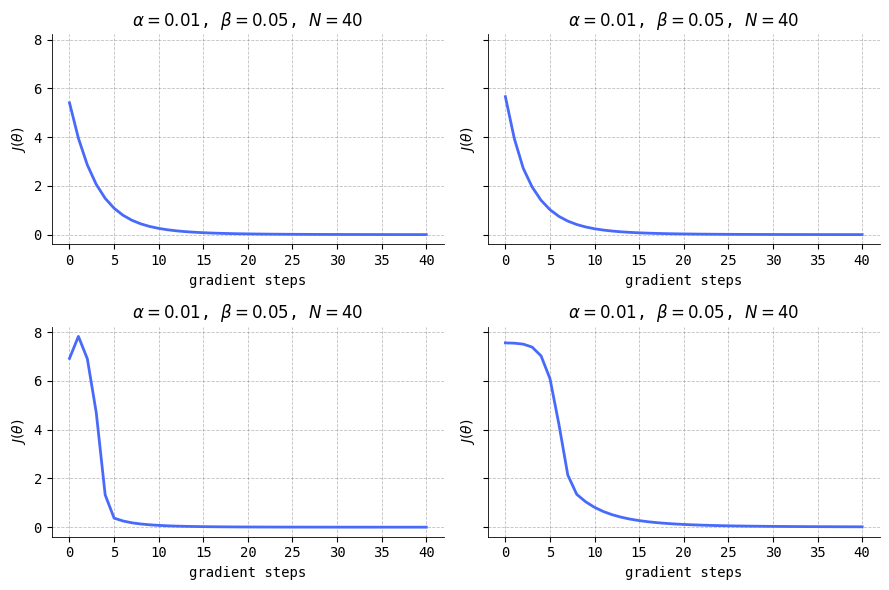

In [95]:
# parameters for gradient descent
gd_parameters = {'theta': [torch.tensor([0.25, 0.9], requires_grad=True),
                           torch.tensor([0.25, 1], requires_grad=True),
                           torch.tensor([0.75, 1.2], requires_grad=True),
                           torch.tensor([0.5, 0.49], requires_grad=True)],
                 'num_steps': [40, 40, 40, 40],
                 'lr': [1e-2, 1e-2, 1e-2, 1e-2]}

# run gradient descent and plot
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharey=True)

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    _, running_objectives = GD(**gd_parameters_slice, J=J, lr_decay_rate=0.05)
    lr = gd_parameters_slice['lr']
    num_steps = gd_parameters_slice['num_steps']
    axis.plot(range(len(running_objectives)), running_objectives)
    axis.set_xlabel('gradient steps')
    axis.set_ylabel('$J(\\theta)$')
    axis.set_title(fr'$\alpha={lr}$, $\beta=0.05$, $N={num_steps}$')
plt.tight_layout()

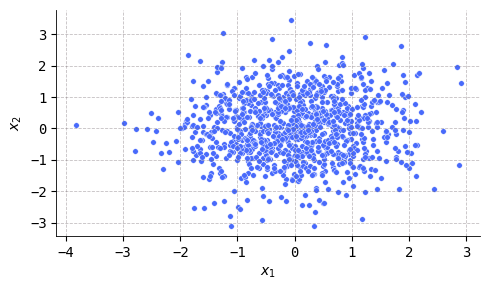

In [13]:
torch.manual_seed(42)
dataset = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.eye(2)).sample(sample_shape=(1024,))

sns.scatterplot(x=dataset[:, 0], y=dataset[:, 1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()


/Users/johnmyers/miniconda3/envs/python-2023-12/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


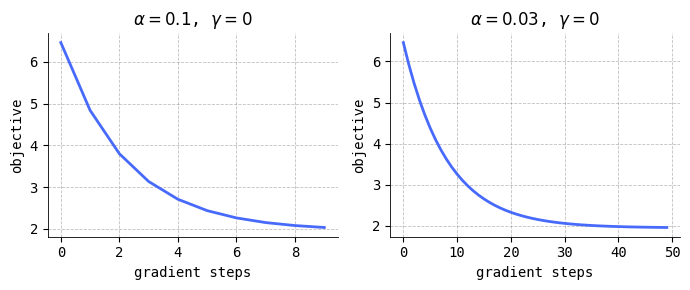

In [14]:
def SGD(parameters, dataset, J, num_epochs, batch_size, lr, tracking, decay=0, max_steps=-1, shuffle=True, random_state=None):

    # define data loader
    if random_state is not None:
        torch.manual_seed(random_state)
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    
    # initialize lists and a dictionary to track objectives and parameters
    running_objectives = []
    running_parameters = {name: [] for name in parameters.keys()}
    step_count = 0

    # begin looping through epochs
    for t in range(num_epochs):
        
        # initialize a list to track per-step objectives. this will only be used if
        # tracking is set to 'epoch'
        per_step_objectives = []
        
        # begin gradient descent loop
        for mini_batch in data_loader:
            
            # compute objective with current parameters
            objective = J(mini_batch, parameters)

            # if we are tracking per gradient step, then add objective value and parameters to the 
            # running lists. otherwise, we are tracking per epoch, so add the objective value to
            # the list of per-step objectives
            if tracking == 'gd_step':
                running_objectives.append(objective.detach().view(1))
                for name, parameter in parameters.items():
                    running_parameters[name].append(parameter.detach().clone())
            else:
                per_step_objectives.append(objective.detach().view(1))
        
            # compute gradients    
            objective.backward()

            # take a gradient step and update the parameters
            with torch.no_grad():
                for parameter in parameters.values():
                    g = ((1 - decay) ** (t + 1)) * parameter.grad
                    parameter -= lr * g
            
            # zero out the gradients to prepare for the next iteration
            for parameter in parameters.values():
                parameter.grad.zero_()

            # if we hit the maximum number of gradient steps, break out of the inner `for`
            # loop
            step_count += 1
            if step_count == max_steps:
                break
        
        # if we are tracking per epoch, then add the average per-step objective to the
        # list of running objectives. also, add the current parameters to the list of running
        # parameters
        if tracking == 'epoch':
            per_step_objectives = torch.row_stack(per_step_objectives)
            running_objectives.append(torch.mean(per_step_objectives))
            for name, parameter in parameters.items():
                running_parameters[name].append(parameter.detach().clone())
        
        # if we hit the maximum number of gradient steps, break out of the outer `for`
        # loop
        if step_count == max_steps:
            break
            
    # output tensors instead of lists
    running_parameters = {name: torch.row_stack(l) for name, l in running_parameters.items()}
    running_objectives = torch.row_stack(running_objectives)
    
    return running_parameters, running_objectives

# define the objective function
def g(x, parameters):
    if not isinstance(parameters, dict):
        raise TypeError('Parameters must be a dictionary of tensors.')
    theta = list(parameters.values())[0]
    return torch.norm(theta - x, dim=1) ** 2

def J(x, parameters):
    return torch.mean(g(x, parameters))

# get grids for contour plots
linspace = torch.linspace(start=-2, end=2, steps=200)
grid_1, grid_2 = torch.meshgrid(linspace, linspace)
grid = torch.column_stack(tensors=(grid_1.reshape(-1, 1), grid_2.reshape(-1, 1)))
z_list = []
for theta in grid:
    z_list.append(J(dataset, {'theta': theta}))
z = torch.row_stack(tensors=z_list).reshape(shape=grid_1.shape)

# gradient descent parameters
batch_size = len(dataset)
random_state = 42
gd_parameters = {'num_epochs': [10, 50],
                 'lr': [1e-1, 3e-2]}
parameters_list = []
objectives_list = []

# run gradient descent
for i in range(2):
    parameters = {'theta': torch.tensor([1.5, 1.5], requires_grad=True)}
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    running_parameters, running_objectives = SGD(parameters=parameters,
                                                 dataset=dataset,
                                                 J=J,
                                                 tracking='gd_step',
                                                 batch_size=batch_size,
                                                 random_state=random_state,
                                                 **gd_parameters_slice)
    parameters_list.append(running_parameters)
    objectives_list.append(running_objectives)

# plot the objective function
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

for i in range(2):
    objectives = objectives_list[i]
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    lr = gd_parameters_slice['lr']
    axes[i].plot(range(len(objectives)), objectives)
    axes[i].set_xlabel('gradient steps')
    axes[i].set_ylabel('objective')
    axes[i].set_title(fr'$\alpha={lr}$, $\gamma=0$')

plt.tight_layout()

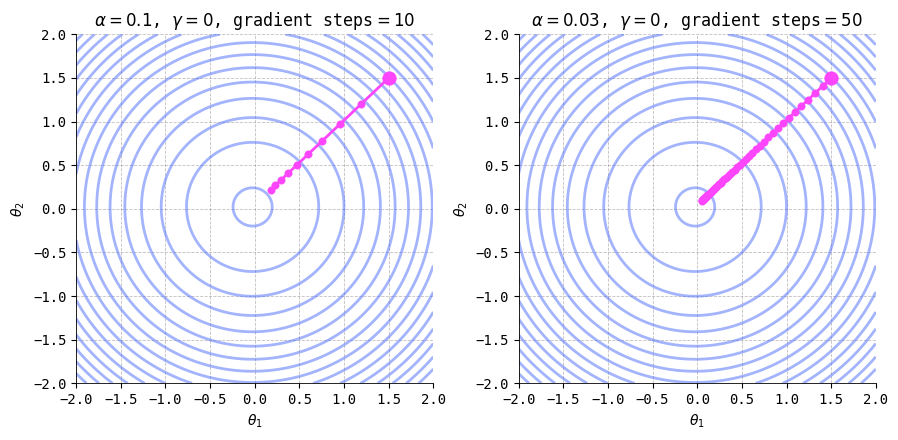

In [15]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.5))

for i in range(2):
    running_parameters = parameters_list[i]['theta']
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    lr = gd_parameters_slice['lr']
    num_epochs = gd_parameters_slice['num_epochs']
    axes[i].contour(grid_1, grid_2, z, levels=torch.arange(start=0, end=10, step=0.5), colors=blue, alpha=0.5)
    axes[i].plot(running_parameters[:, 0], running_parameters[:, 1], color=magenta)
    axes[i].scatter(running_parameters[:, 0], running_parameters[:, 1], s=30, color=magenta, zorder=2)
    axes[i].scatter(running_parameters[0, 0], running_parameters[0, 1], s=100, color=magenta, zorder=2)
    axes[i].set_title(fr'$\alpha={lr}$, $\gamma=0$, gradient steps$={num_epochs}$')
    axes[i].set_xlabel(r'$\theta_1$')
    axes[i].set_ylabel(r'$\theta_2$')

plt.tight_layout()

NameError: name 'axes_idx' is not defined

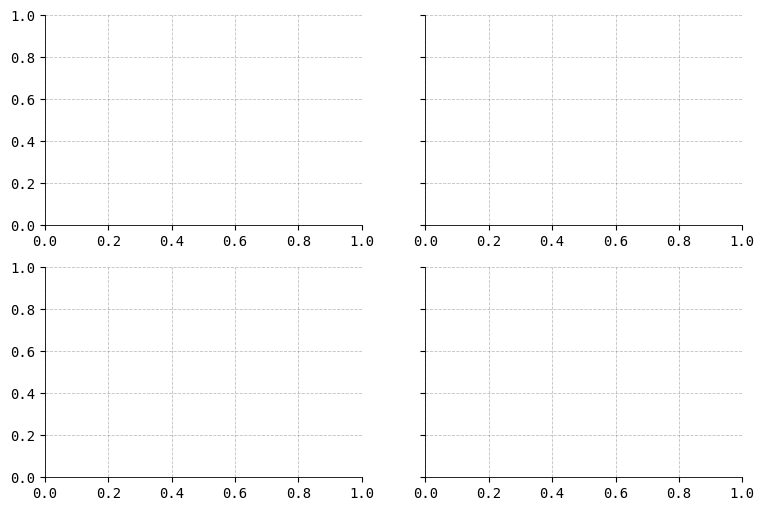

In [16]:
# SGD parameters
num_epochs = 1
batch_size = 1
random_state = 42
gd_parameters = {'lr': [1e-1, 1e-1, 3e-2, 3e-2],
               'max_steps': [10, 100, 80, 160]}
parameters_list = []
objectives_list = []

# run SGD
for i in range(4):
    parameters = {'theta': torch.tensor([1.5, 1.5], requires_grad=True)}
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    running_parameters, running_objectives = SGD(parameters=parameters,
                                                 dataset=dataset,
                                                 J=J,
                                                 tracking='gd_step',
                                                 num_epochs=1,
                                                 batch_size=batch_size,
                                                 random_state=random_state,
                                                 **gd_parameters_slice)
    parameters_list.append(running_parameters)
    objectives_list.append(running_objectives)

# plot the objective function
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharey=True)

for i in range(4):
    idx = axes_idx[i]
    objectives = objectives_list[i]
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    lr = gd_parameters_slice['lr']
    axes[idx].plot(range(len(objectives)), objectives)
    axes[idx].set_xlabel('gradient steps')
    axes[idx].set_ylabel('objective')
    axes[idx].set_title(fr'$\alpha={lr}$, $\gamma=0$')

plt.tight_layout()

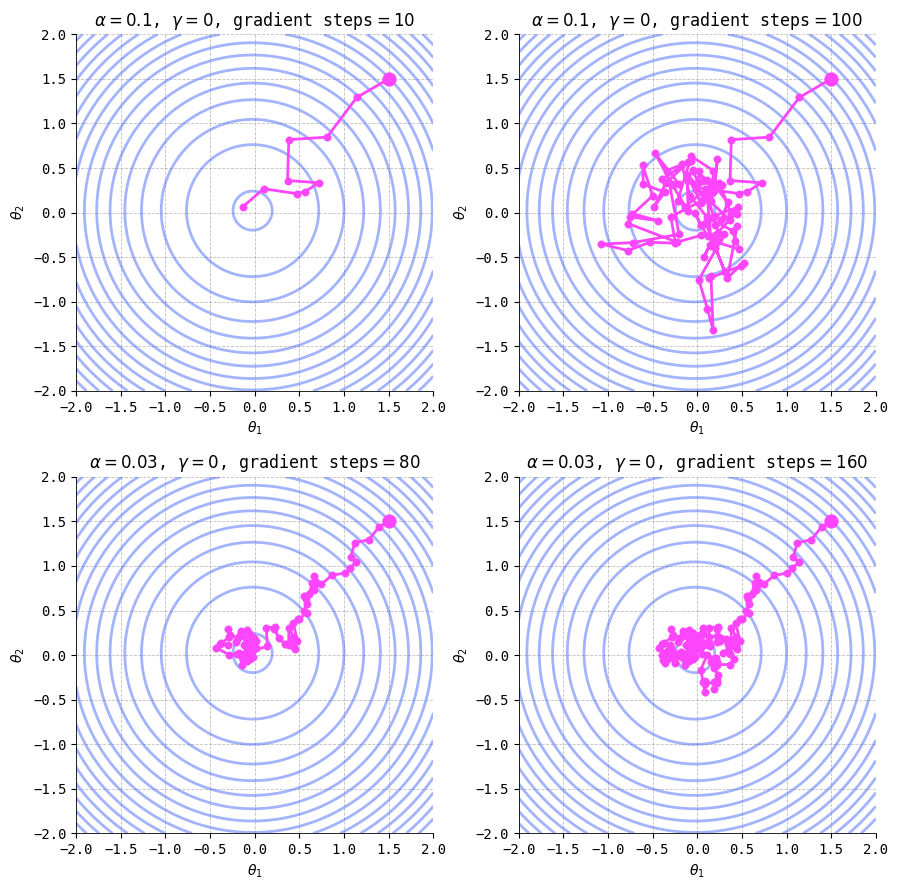

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

for i in range(4):
    idx = axes_idx[i]
    running_parameters = parameters_list[i]['theta']
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    lr = gd_parameters_slice['lr']
    max_steps = gd_parameters_slice['max_steps']
    axes[idx].contour(grid_1, grid_2, z, levels=torch.arange(start=0, end=10, step=0.5), colors=blue, alpha=0.5)
    axes[idx].plot(running_parameters[:, 0], running_parameters[:, 1], color=magenta)
    axes[idx].scatter(running_parameters[:, 0], running_parameters[:, 1], s=30, color=magenta, zorder=2)
    axes[idx].scatter(running_parameters[0, 0], running_parameters[0, 1], s=100, color=magenta, zorder=2)
    axes[idx].set_title(rf'$\alpha={lr}$, $\gamma=0$, gradient steps$={max_steps}$')
    axes[idx].set_xlabel(r'$\theta_1$')
    axes[idx].set_ylabel(r'$\theta_2$')

plt.tight_layout()

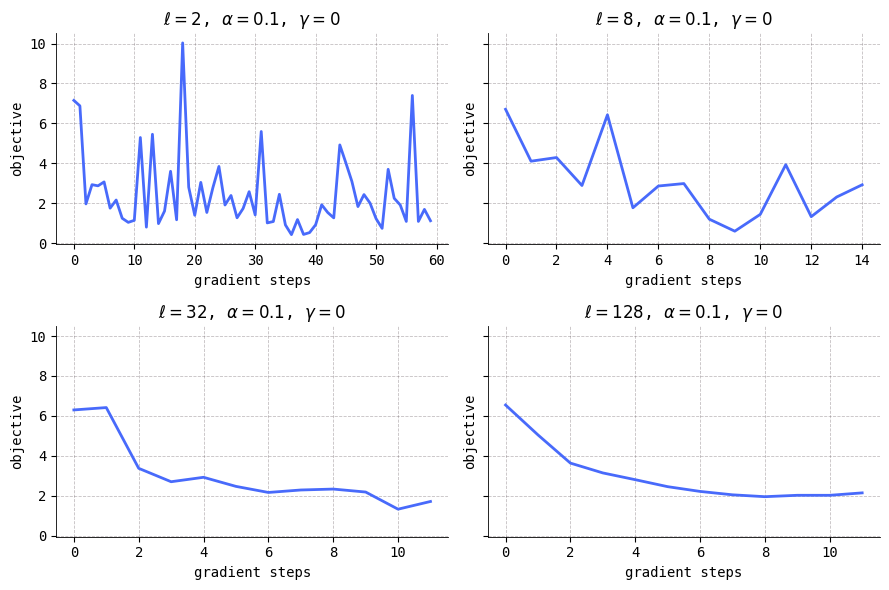

In [ ]:
# mini-batch gradient descent parameters
random_state = 42
gd_parameters = {'num_epochs': [1, 1, 1, 2],
               'lr': [1e-1, 1e-1, 1e-1, 1e-1],
               'batch_size': [2, 8, 32, 128],
               'max_steps': [60, 15, 12, 12]}
parameters_list = []
objectives_list = []

# run mini-batch gradient descent
for i in range(4):
    parameters = {'theta': torch.tensor([1.5, 1.5], requires_grad=True)}
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    running_parameters, running_objectives = SGD(parameters=parameters,
                             dataset=dataset,
                             J=J,
                             tracking='gd_step',
                             random_state=random_state,
                             **gd_parameters_slice)
    parameters_list.append(running_parameters)
    objectives_list.append(running_objectives)

# plot the objective function
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharey=True)

for i in range(4):
    idx = axes_idx[i]
    objectives = objectives_list[i]
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    batch_size = gd_parameters_slice['batch_size']
    lr = gd_parameters_slice['lr']
    axes[idx].plot(range(len(objectives)), objectives)
    axes[idx].set_xlabel('gradient steps')
    axes[idx].set_ylabel('objective')
    axes[idx].set_title(rf'$\ell={batch_size}$, $\alpha={lr}$, $\gamma=0$')

plt.tight_layout()

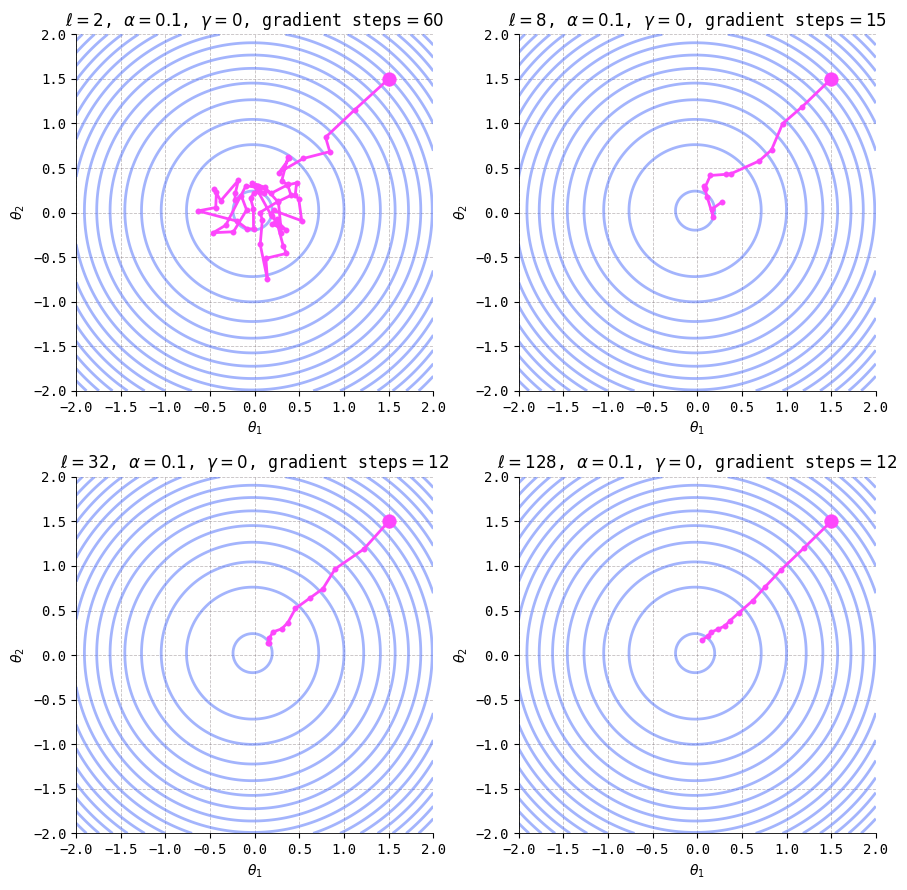

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

for i in range(4):
    idx = axes_idx[i]
    running_parameters = parameters_list[i]['theta']
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    batch_size = gd_parameters_slice['batch_size']
    lr = gd_parameters_slice['lr']
    max_steps = gd_parameters_slice['max_steps']
    total_data_points = batch_size * max_steps
    axes[idx].contour(grid_1, grid_2, z, levels=torch.arange(start=0, end=10, step=0.5), colors=blue, alpha=0.5)
    axes[idx].plot(running_parameters[:, 0], running_parameters[:, 1], color=magenta)
    axes[idx].scatter(running_parameters[:, 0], running_parameters[:, 1], color=magenta, zorder=2)
    axes[idx].scatter(running_parameters[0, 0], running_parameters[0, 1], s=100, color=magenta, zorder=2)
    axes[idx].set_title(rf'$\ell={batch_size}$, $\alpha={lr}$, $\gamma=0$, gradient steps$={max_steps}$')
    axes[idx].set_xlabel(r'$\theta_1$')
    axes[idx].set_ylabel(r'$\theta_2$')

plt.tight_layout()